In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import bioframe
import numpy as np
import seaborn as sns
from pybedtools import BedTool
import re

import os
import matplotlib
figure_width = 5
matplotlib.rcParams['font.size'] = 10
saveFigs = True 
if saveFigs == True:
    figure_path = '../figs/figure2/'
    os.makedirs(figure_path, exist_ok=True)
    # to save inkscape-friendly svgs
    new_rc_params = {'text.usetex': False,
                     "svg.fonttype": 'none'}
    matplotlib.rcParams.update(new_rc_params)
annotation = 'HMM5'

In [26]:
gm_df = pd.read_csv('../annotations/GM12878_hg38_25kb.tsv', sep = '\t')
gm_df.head()

,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,E3,binary,HMM2,HMM3,HMM3P,HMM5,HMM7
0,chr1,0,25000,NaN,0.002548,0.034406,NaN,0.573067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,25000,50000,NaN,0.001826,0.029127,NaN,0.430960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,50000,75000,NaN,0.019703,0.095678,NaN,0.351400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,75000,100000,NaN,0.004713,0.046797,NaN,0.402080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,100000,125000,NaN,0.019023,0.094014,NaN,0.371200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
nucleotides = gm_df['end'] - gm_df['start']

In [28]:
for i in gm_df.HMM3.unique():
    print(i, nucleotides[gm_df.HMM3==i].sum())

nan 0
1.0 823275000
2.0 869725000
0.0 955995973


# GC content and E1

In [29]:
masked_track = gm_df[~gm_df['E1'].isna()]

In [30]:
def get_state_values(hmm_track, hmm, signal,  states = False, clip = False):
    if not states:
        states = hmm_track[hmm].unique()
        states.sort()
    l = []
    for state in states:
        vals = hmm_track[hmm_track[hmm] == state][signal].values
        if clip:
            vals = np.clip(vals, np.percentile(vals, 1), np.percentile(vals, 99))
        l.append(vals)
    return l

In [31]:
gc_states = get_state_values(masked_track, annotation,'GC')

In [32]:
labels=['B', 'Mbb', 'M', 'Maa', 'A']

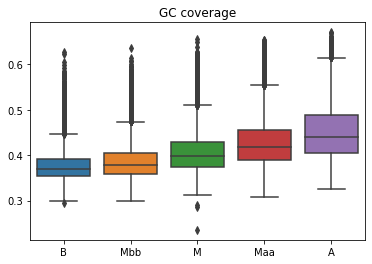

In [33]:
sns.boxplot(data=gc_states)
plt.gca().set_xticklabels(labels);
plt.title('GC coverage')

if saveFigs:
    plt.savefig(figure_path+'GC content_'+annotation+'.svg', bbox_inches='tight')

In [34]:
E1_states = get_state_values(masked_track, annotation,'E1')

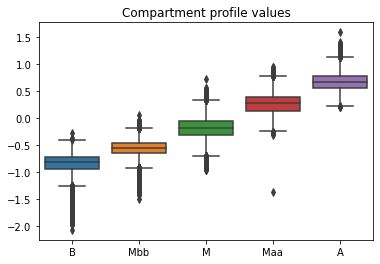

In [35]:
sns.boxplot(data=E1_states)
plt.gca().set_xticklabels(labels);
plt.title('Compartment profile values')

if saveFigs:
    plt.savefig(figure_path+'Compartment_profile_values_'+annotation+'.svg', bbox_inches='tight')

# Gene expression

In [36]:
gencode = pd.read_csv('../data/gencode.v37.annotation.gff3.gz',
               names=['chrom','annot','type','start','stop','na1','strand','na2','genestuff'],
                      delimiter='\t',skiprows=7)

genes = gencode.loc[gencode['type'].values=='gene']
genes.rename(columns={'stop':'end'}, inplace=True)
genes = genes.astype({'start':int,'end':int})
### need to join gene table & expression table
geneNames =  genes['genestuff'].str.split(';')
genes['Description'] = [i[3].split('=')[1] for i in geneNames]
genes['Name'] = [i[0].split('=')[1] for i in geneNames]
genes.head()

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,chrom,annot,type,start,end,na1,strand,na2,genestuff,Description,Name
0,chr1,HAVANA,gene,11869,14409,.,+,.,ID=ENSG00000223972.5;gene_id=ENSG00000223972.5...,DDX11L1,ENSG00000223972.5
12,chr1,HAVANA,gene,14404,29570,.,-,.,ID=ENSG00000227232.5;gene_id=ENSG00000227232.5...,WASH7P,ENSG00000227232.5
25,chr1,ENSEMBL,gene,17369,17436,.,-,.,ID=ENSG00000278267.1;gene_id=ENSG00000278267.1...,MIR6859-1,ENSG00000278267.1
28,chr1,HAVANA,gene,29554,31109,.,+,.,ID=ENSG00000243485.5;gene_id=ENSG00000243485.5...,MIR1302-2HG,ENSG00000243485.5
36,chr1,ENSEMBL,gene,30366,30503,.,+,.,ID=ENSG00000284332.1;gene_id=ENSG00000284332.1...,MIR1302-2,ENSG00000284332.1


In [37]:
expression = pd.read_csv('../data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct.gz'
               ,delimiter='\t', skiprows = 2)
expression.head()

,Name,Description,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
0,ENSG00000223972.5,DDX11L1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.166403,0.00000,0.00000,0.00000,0.00000
1,ENSG00000227232.5,WASH7P,4.06403,3.37111,2.68549,4.04762,3.90076,3.63963,5.16375,1.43859,...,5.93298,6.13265,4.19378,5.92631,3.06248,4.702530,6.27255,7.19001,5.74554,2.64743
2,ENSG00000278267.1,MIR6859-1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000
3,ENSG00000243485.5,MIR1302-2HG,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.054223,0.00000,0.00000,0.00000,0.00000
4,ENSG00000237613.2,FAM138A,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000


In [38]:
t = expression.set_index('Name').join(genes.set_index('Name'),rsuffix='_')

In [39]:
expressed_genes = t.copy()
expressed_genes.reset_index(inplace=True)
expressed_genes = expressed_genes[['chrom','start','end','strand','Cells - EBV-transformed lymphocytes']]
expressed_genes = expressed_genes.iloc[~pd.isnull(expressed_genes['chrom'].values)]
expressed_genes.sort_values(['chrom','start','end'],inplace=True)
expressed_genes['start'] = expressed_genes['start'].values.astype(int) #since just using .astype() method wasn't working..
expressed_genes['end'] = expressed_genes['end'].values.astype(int)
expressed_genes = expressed_genes[expressed_genes['chrom'].isin(gm_df.chrom.unique())] #Filters out chroms not available in Hi-C HMM

In [40]:
expressed_genes

,chrom,start,end,strand,Cells - EBV-transformed lymphocytes
0,chr1,11869,14409,+,0.000000
1,chr1,14404,29570,-,2.494770
2,chr1,17369,17436,-,0.000000
3,chr1,29554,31109,+,0.000000
4,chr1,34554,36081,-,0.000000
...,...,...,...,...,...
27188,chr9,138150075,138177433,+,0.102107
27189,chr9,138177426,138179774,-,0.000000
27190,chr9,138199933,138203325,-,0.000000
27192,chr9,138259595,138259698,+,0.000000


In [41]:
from bioframe.util import bedtools
def bedtools_intersect_basePairs(left, right, rsuffix='_', **kwargs):
    """
    >>> ixn = bedtools_intersect(bed1, bed2, wao=True), needed to delete other keys b/c they clashed
   """
    
    out = bedtools.intersect(a=left, b=right,wao=True)
    out.columns = list(left.columns) + [c+rsuffix if c in left.columns else c for c in right.columns] + ['bpOverlap']
    return out

In [42]:
gm_df

,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,E3,binary,HMM2,HMM3,HMM3P,HMM5,HMM7
0,chr1,0,25000,NaN,0.002548,0.034406,NaN,0.573067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,25000,50000,NaN,0.001826,0.029127,NaN,0.430960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,50000,75000,NaN,0.019703,0.095678,NaN,0.351400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,75000,100000,NaN,0.004713,0.046797,NaN,0.402080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,100000,125000,NaN,0.019023,0.094014,NaN,0.371200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115004,chr22,50700000,50725000,0.919536,1.621853,0.902310,0.003883,0.582120,-0.273457,0.576923,0.259086,0.0,0.0,1.0,2.0,2.0,3.0
115005,chr22,50725000,50750000,0.934506,1.581227,0.890937,0.003675,0.550640,-0.295694,0.546716,0.406209,0.0,0.0,1.0,2.0,2.0,3.0
115006,chr22,50750000,50775000,0.501871,0.752977,0.614810,0.006504,0.438000,-0.140475,0.489133,0.184162,0.0,0.0,1.0,2.0,2.0,3.0
115007,chr22,50775000,50800000,0.347564,0.453748,0.477263,0.009642,0.445800,-0.068095,0.510889,0.228893,0.0,0.0,1.0,2.0,2.0,3.0


In [43]:
intersection = bedtools_intersect_basePairs(gm_df, expressed_genes)

In [44]:
intersection.head()

,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,...,HMM3,HMM3P,HMM5,HMM7,chrom_,start_,end_,strand,Cells - EBV-transformed lymphocytes,bpOverlap
0,chr1,0,25000,NaN,0.002548,0.034406,NaN,0.573067,NaN,NaN,...,NaN,NaN,NaN,NaN,chr1,11869,14409,+,0.00000,2540
1,chr1,0,25000,NaN,0.002548,0.034406,NaN,0.573067,NaN,NaN,...,NaN,NaN,NaN,NaN,chr1,17369,17436,-,0.00000,67
2,chr1,0,25000,NaN,0.002548,0.034406,NaN,0.573067,NaN,NaN,...,NaN,NaN,NaN,NaN,chr1,14404,29570,-,2.49477,10596
3,chr1,25000,50000,NaN,0.001826,0.029127,NaN,0.430960,NaN,NaN,...,NaN,NaN,NaN,NaN,chr1,29554,31109,+,0.00000,1555
4,chr1,25000,50000,NaN,0.001826,0.029127,NaN,0.430960,NaN,NaN,...,NaN,NaN,NaN,NaN,chr1,34554,36081,-,0.00000,1527


In [45]:
mask = (intersection['E1'] == intersection['E1']) & (intersection['Cells - EBV-transformed lymphocytes']>0)

In [46]:
data = []
for i in range(5):
    track = intersection[(mask)&(intersection[annotation]==i)]['Cells - EBV-transformed lymphocytes'].values
    data.append(np.log(track))

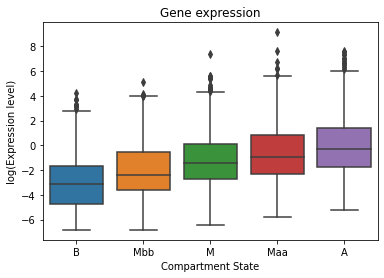

In [47]:
sns.boxplot(data=data)
plt.gca().set_xticklabels(labels);
plt.title('Gene expression')
plt.xlabel('Compartment State')
plt.ylabel('log(Expression level)')

if saveFigs:
    plt.savefig(figure_path+'Gene_expression_'+annotation+'.svg', bbox_inches='tight')

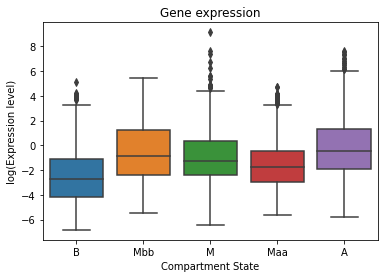

In [24]:
sns.boxplot(data=data)
plt.gca().set_xticklabels(labels);
plt.title('Gene expression')
plt.xlabel('Compartment State')
plt.ylabel('log(Expression level)')

if saveFigs:
    plt.savefig(figure_path+'Gene_expression_'+annotation+'.svg', bbox_inches='tight')